In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout,BatchNormalization
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

In [ ]:
x = []
y = []

target_size = (28, 28) 

for k in range(0, 10):
    class_dir = os.path.join('dataset_farsi', str(k))
    if not os.path.exists(class_dir):
        print(f"Directory {class_dir} not found, skipping")
        continue
        
    for file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, file)
        
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Could not read {img_path}, skipping")
                continue
                
        
            if img.shape != target_size:
                img = cv2.resize(img, target_size)
                
            # Invertinh
            img = cv2.bitwise_not(img)
            img = img.astype(np.float32) / 255.0
            
            
            if len(img.shape) == 2:
                img = np.expand_dims(img, axis=-1)
                
            
            if img.shape != (target_size[0], target_size[1], 1):
                print(f"Unexpected shape {img.shape} for {img_path}, skipping")
                continue
                
            x.append(img)
            y.append(k)
            
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue


if x:
    first_shape = x[0].shape
    for img in x:
        if img.shape != first_shape:
            print(f"Inconsistent shape found: {img.shape} vs {first_shape}")
    
    # Convert to numpy arrayss
    x = np.array(x)
    y = np.array(y)
    
    # Shuffle the data
    x, y = shuffle(x, y, random_state=42)
    
    print("Data loaded successfully")
    print("Input shape:", x.shape)
    print("Labels shape:", y.shape)
else:
    print("No valid images found in the dataset")

Data loaded successfully
Input shape: (80000, 28, 28, 1)
Labels shape: (80000,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
np.savez('persian_digits.npz', x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test)

In [ ]:
#load the persian digits.npz datase
data = np.load('persian_digits.npz')
X_train = data['x_train']
y_train = data['y_train']
X_test = data['x_test']
y_test = data['y_test']
# Check the shapes of the loaded data
print("Loaded data shapes:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


Loaded data shapes:
X_train shape: (64000, 28, 28, 1)
y_train shape: (64000,)
X_test shape: (16000, 28, 28, 1)
y_test shape: (16000,)


In [14]:
# Create a simple neural network model
num_filters = 32  # Number of filters for convolutional layers
filter_size = (3, 3)  # Size of the filters
pool_size = (2, 2)  # Size of the pooling window
model = Sequential(
    [
    Conv2D(num_filters, filter_size, activation='relu',padding='same', input_shape=(28, 28, 1)), #input layer
    BatchNormalization(),
    MaxPooling2D(pool_size), #pooling layer
    Conv2D(64, filter_size, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size),
    Flatten(), #flattening layer
    Dense(512, activation='relu'), #hidden layer
    BatchNormalization(), 
    Dropout(0.5),
    Dense(256, activation='relu'), #hidden layer
    Dense(128, activation = 'relu'),
    Dense(10, activation='softmax') #output layer (10 class for 0-9 digits)
]
)
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_3 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                      

In [15]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#callback
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

In [17]:
X_train.shape

(64000, 28, 28, 1)

In [19]:
# Train the model
history = model.fit(X_train, y_train,
                     epochs=15,
                     batch_size=32,
                     validation_data=(X_test, y_test),
                     validation_split=0.2,
                     callbacks=callbacks)

Epoch 1/15
2000/2000 [==============================] - 55s 27ms/step - loss: 0.0949 - accuracy: 0.9713 - val_loss: 0.0303 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 2/15
   3/2000 [..............................] - ETA: 1:10 - loss: 0.0135 - accuracy: 1.0000

C:\Users\USer\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2000/2000 [==============================] - 50s 25ms/step - loss: 0.0437 - accuracy: 0.9872 - val_loss: 0.0730 - val_accuracy: 0.9768 - lr: 0.0010
Epoch 3/15
2000/2000 [==============================] - 54s 27ms/step - loss: 0.0335 - accuracy: 0.9900 - val_loss: 0.0327 - val_accuracy: 0.9919 - lr: 0.0010
Epoch 4/15
2000/2000 [==============================] - 51s 26ms/step - loss: 0.0290 - accuracy: 0.9917 - val_loss: 0.0229 - val_accuracy: 0.9930 - lr: 0.0010
Epoch 5/15
2000/2000 [==============================] - 73s 37ms/step - loss: 0.0250 - accuracy: 0.9930 - val_loss: 0.0231 - val_accuracy: 0.9942 - lr: 0.0010
Epoch 6/15
2000/2000 [==============================] - 50s 25ms/step - loss: 0.0223 - accuracy: 0.9938 - val_loss: 0.0199 - val_accuracy: 0.9954 - lr: 0.0010
Epoch 7/15
2000/2000 [==============================] - 51s 25ms/step - loss: 0.0189 - accuracy: 0.9949 - val_loss: 0.0222 - val_accuracy: 0.9954 - lr: 0.0010
Epoch 8/15
2000/2000 [==============================] - 5

500/500 - 4s - loss: 0.0138 - accuracy: 0.9976 - 4s/epoch - 8ms/step

Test accuracy: 0.9975625276565552


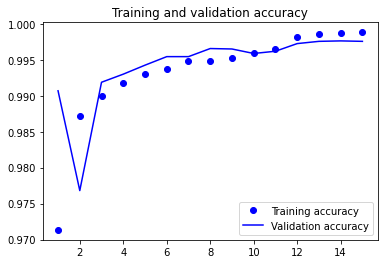

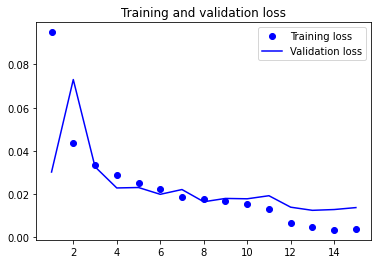

In [20]:
#evalualting the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
#plotting the accuracy and loss of the model
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy') #'bo' is the color of the line
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [21]:
#saving the model
model.save('model/persion_ocr.h5')

C:\Users\USer\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
#load the model
model.load_weights('model/persion_ocr.h5')

In [24]:
#prediction
prediction = model.predict(X_test)

500/500 [==============================] - 4s 8ms/step


In [ ]:
class_names = [0,1,2,3,4,5,6,7,8,9]
num = int(input("Please enter the number of the image you want to test: ")) #taking input from the user


m = -1000
o2 = prediction[num]
ind = -1

for i in range(len(o2)):
    if o2[i] > m:
        m = o2[i]
        ind = i
print("The predicted class is: ", class_names[ind]) #printing the predicted class
print("The real answer is : ", class_names[y_test[num]]) #printing the real answer

The predicted class is:  8
The real answer is :  8


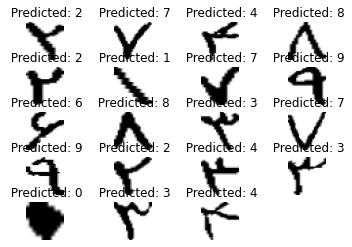

In [ ]:
for i in range(19):
    plt.subplot(5, 4, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f" Predicted: {np.argmax(prediction[i])}") #argmax is the highest predicted chance in the array 
    plt.axis('off')
plt.show()